In [393]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)

%matplotlib inline

### Nacitame

In [366]:
le = LabelEncoder()
users = pd.read_csv("027/user.csv", encoding="utf_8", sep='\t')
sessions = pd.read_csv("027/session.csv", encoding="utf_8", sep='\t')
cur_date = pd.Timestamp.now()

## Integracia a cistenie dat
## Users
### Dropneme duplicatne user_id

In [367]:
users.user_id.duplicated().sum()
users = users.drop_duplicates(subset='user_id', keep='first')

### Pridame age, izolujeme stlpce ktore maju pre preprocessing zmysel a zistime pocet ich nan hodnot

In [368]:
users['birthdate'] = pd.to_datetime(users.birthdate, format='mixed')
users['age'] = cur_date.year - users['birthdate'].dt.year
users = users[['age', 'race', 'sex', 'user_id']]
users.isnull().sum()

age         736
race       1148
sex         832
user_id       0
dtype: int64

### Pre age nan nahradime s mean

In [369]:
users['age'].fillna(users['age'].mean(), inplace=True)
users['age'] = users['age'].astype('int32')

### Pre race nan nahradime s unspecified a pouzijeme Label Encoding

In [370]:
users['race'].fillna('unspecified', inplace=True)
users['race'] = le.fit_transform(users['race'])

for encoded_value in set(users['race']):
    original_value = le.inverse_transform([encoded_value])[0]
    print(f"Encoded Value: {encoded_value}, Original Value: {original_value}")


Encoded Value: 0, Original Value: asian
Encoded Value: 1, Original Value: black
Encoded Value: 2, Original Value: indian
Encoded Value: 3, Original Value: unspecified
Encoded Value: 4, Original Value: white


### Pre sex pouzijeme One-Hot Encoding

In [371]:
users = pd.get_dummies(users, columns=['sex'], prefix='sex')

In [372]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1639 entries, 0 to 2570
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   age      1639 non-null   int32
 1   race     1639 non-null   int32
 2   user_id  1639 non-null   int64
 3   sex_F    1639 non-null   bool 
 4   sex_M    1639 non-null   bool 
dtypes: bool(2), int32(2), int64(1)
memory usage: 41.6 KB


### Vychylene hodnoty riesime pozorovanim

In [373]:
users = users[(users['age'] >= 15) & (users['age'] <= 100)]

## Sessions
### Vyhodime product_ean

In [374]:
sessions = sessions.drop(columns=['product_ean'])

In [375]:
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11059 entries, 0 to 11058
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   pct_scroll_move_duration        11048 non-null  float64
 1   pct_click_product_info          11048 non-null  float64
 2   pct_click                       11047 non-null  float64
 3   pct_rage_click                  11048 non-null  float64
 4   pct_mouse_move                  11048 non-null  float64
 5   wild_mouse_duration             11048 non-null  float64
 6   pct_wild_mouse                  11048 non-null  float64
 7   session_id                      11059 non-null  int64  
 8   scroll_move_total_rel_distance  11048 non-null  float64
 9   pct_scrandom                    11047 non-null  float64
 10  total_load_time                 11059 non-null  float64
 11  screen_height                   11059 non-null  object 
 12  page_activity_duration          

### Browser name Label Encoding

In [376]:
sessions['browser_name'] = le.fit_transform(sessions['browser_name'])

for encoded_value in set(sessions['browser_name']):
    original_value = le.inverse_transform([encoded_value])[0]
    print(f"Encoded Value: {encoded_value}, Original Value: {original_value}")

Encoded Value: 0, Original Value: chrome
Encoded Value: 1, Original Value: edge
Encoded Value: 2, Original Value: firefox
Encoded Value: 3, Original Value: mobile
Encoded Value: 4, Original Value: opera
Encoded Value: 5, Original Value: other
Encoded Value: 6, Original Value: safari


### Screen width, height mean, replace lower, higher

In [377]:
columns_to_process = ['screen_height', 'screen_width']

for column in columns_to_process:
    sessions[column] = pd.to_numeric(sessions[column], errors='coerce')
    average_value = sessions[column].mean()
    sessions[column].fillna(average_value, inplace=True)
    sessions[column] = sessions[column].astype(int)

    unique_values = sessions[column].unique()
    print(f"Unique values for {column}: {unique_values}")

Unique values for screen_height: [ 768 1080  800  600  862 1024]
Unique values for screen_width: [1024 1280 1366 1920 1313  800]


### Extract hour from session_start

In [378]:
sessions['session_start'] = pd.to_datetime(sessions['session_start'])

sessions['hour_of_day'] = sessions['session_start'].dt.hour
sessions = sessions.drop(columns=['session_start'])

In [379]:
sessions.isnull().sum()

pct_scroll_move_duration          11
pct_click_product_info            11
pct_click                         12
pct_rage_click                    11
pct_mouse_move                    11
wild_mouse_duration               11
pct_wild_mouse                    11
session_id                         0
scroll_move_total_rel_distance    11
pct_scrandom                      12
total_load_time                    0
screen_height                      0
page_activity_duration            11
pct_scroll_move                   11
session_duration                   0
pct_doubleclick                   11
ack                                0
user_id                            0
mouse_move_total_rel_distance     11
pct_input                         11
screen_width                       0
browser_name                       0
pct_mouse_click                   11
hour_of_day                        0
dtype: int64

### Zvysne nan stlpce doplnime pomocou kNN, kde k=5

In [380]:
columns_with_missing_values = sessions.columns[sessions.isna().any()].tolist()
sessions_missing_values = sessions[columns_with_missing_values].copy()
knn_imputer = KNNImputer(n_neighbors=5)
sessions_imputed_values = pd.DataFrame(knn_imputer.fit_transform(sessions_missing_values), columns=columns_with_missing_values)
sessions[columns_with_missing_values] = sessions_imputed_values

In [381]:
sessions.isnull().sum()

pct_scroll_move_duration          0
pct_click_product_info            0
pct_click                         0
pct_rage_click                    0
pct_mouse_move                    0
wild_mouse_duration               0
pct_wild_mouse                    0
session_id                        0
scroll_move_total_rel_distance    0
pct_scrandom                      0
total_load_time                   0
screen_height                     0
page_activity_duration            0
pct_scroll_move                   0
session_duration                  0
pct_doubleclick                   0
ack                               0
user_id                           0
mouse_move_total_rel_distance     0
pct_input                         0
screen_width                      0
browser_name                      0
pct_mouse_click                   0
hour_of_day                       0
dtype: int64

### Vychylene hodnoty

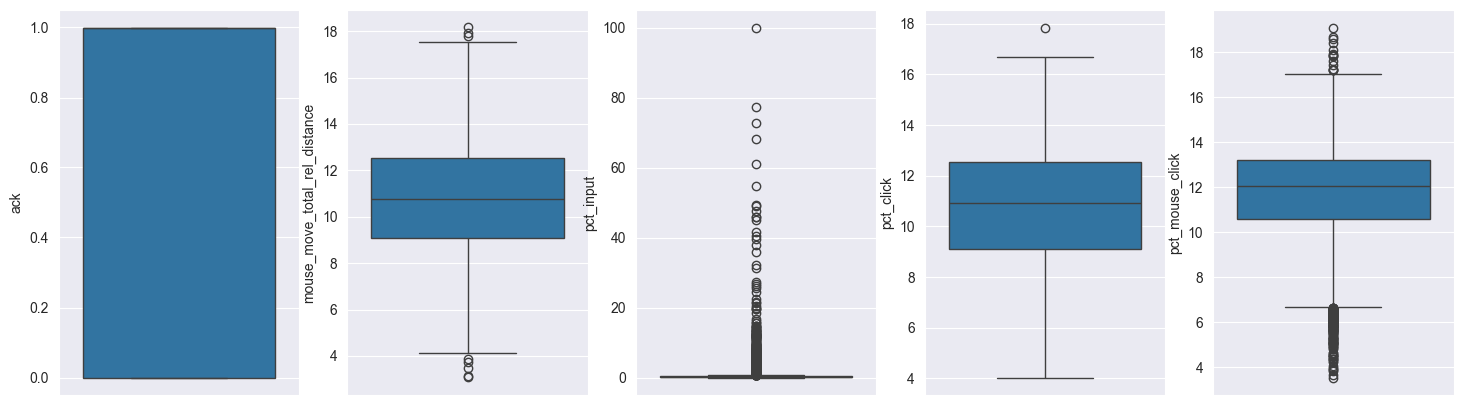

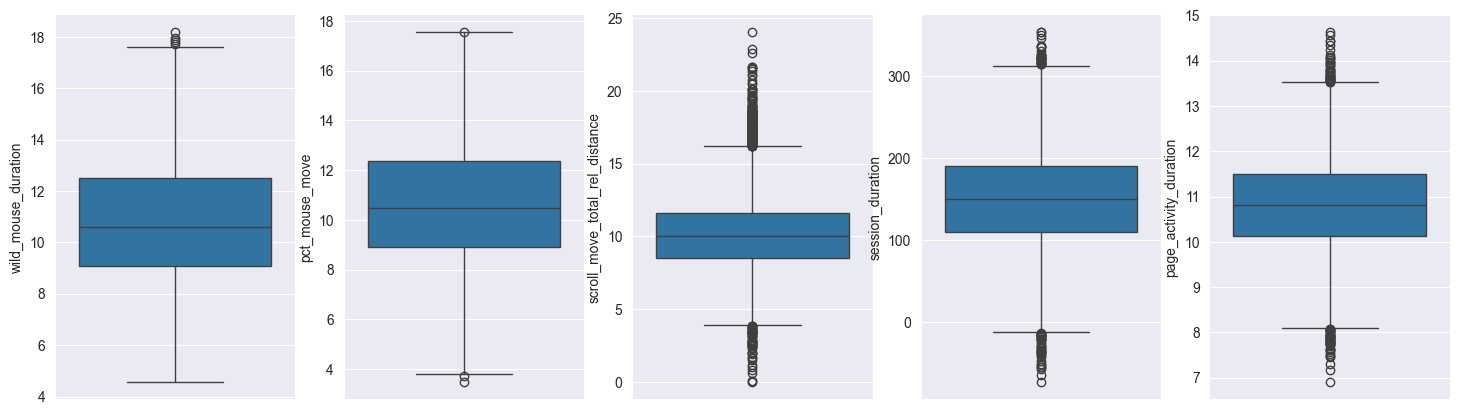

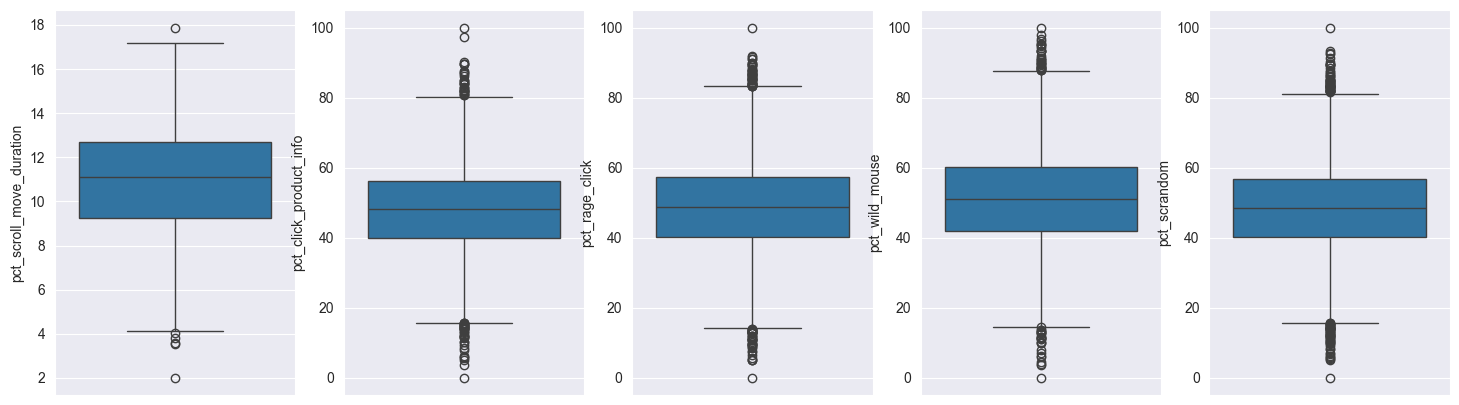

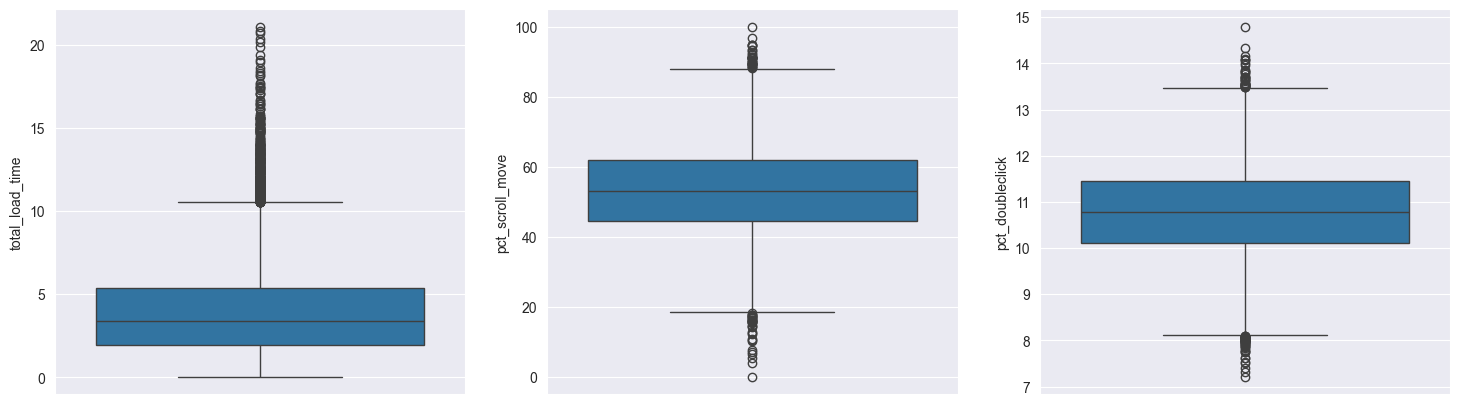

In [382]:
sessions_columns = [
    ["ack", "mouse_move_total_rel_distance", "pct_input", "pct_click", "pct_mouse_click"],
    ["wild_mouse_duration", "pct_mouse_move", "scroll_move_total_rel_distance", "session_duration", "page_activity_duration"],
    ["pct_scroll_move_duration", "pct_click_product_info", "pct_rage_click", "pct_wild_mouse", "pct_scrandom"],
    ["total_load_time", "pct_scroll_move", "pct_doubleclick"]
]
figs = []
axes = []

for i, columns in enumerate(sessions_columns):
    fig, ax = plt.subplots(1, len(columns), figsize=(18, 5))
    figs.append(fig)
    axes.append(ax)

for i, (fig, ax, columns) in enumerate(zip(figs, axes, sessions_columns)):
    for j, column in enumerate(columns):
        sns.boxplot(data=sessions, y=column, ax=ax[j])

plt.show()

### vyhodime sessions s negativnym session_duration

In [383]:
sessions = sessions[sessions['session_duration'] >= 0]

In [384]:
def remove_outliers_iqr(dataframe, column_name, threshold=1.5):
    Q1 = dataframe[column_name].quantile(0.25)
    Q3 = dataframe[column_name].quantile(0.75)
    IQR = Q3 - Q1

    outliers = (dataframe[column_name] < (Q1 - threshold * IQR)) | (dataframe[column_name] > (Q3 + threshold * IQR))
    cleaned_dataframe = dataframe[~outliers]

    return cleaned_dataframe

In [385]:
for column in sessions_columns:
    sessions[column] = remove_outliers_iqr(sessions[column], column)

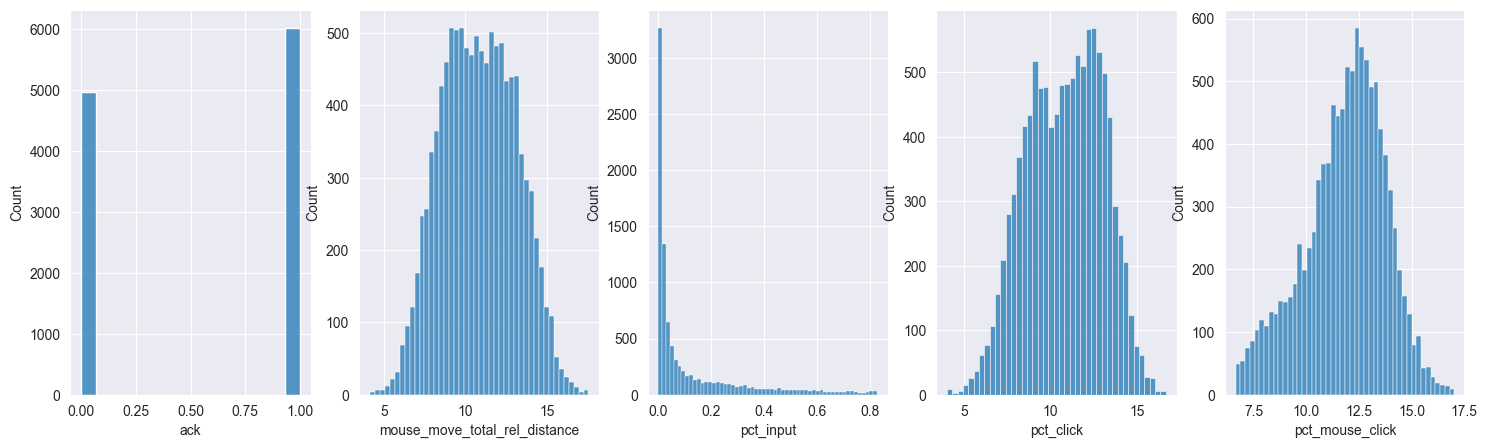

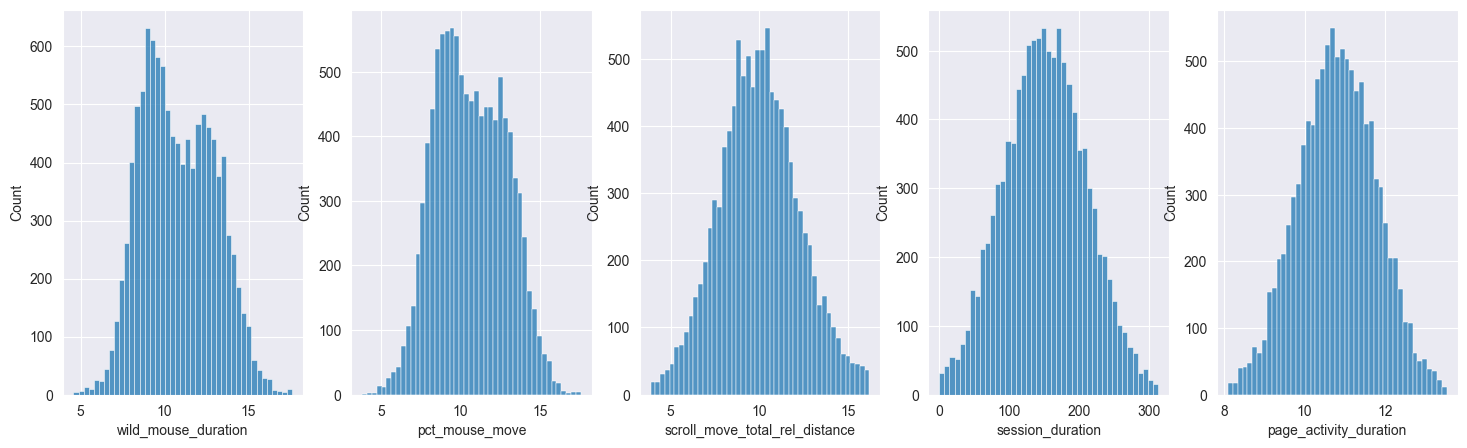

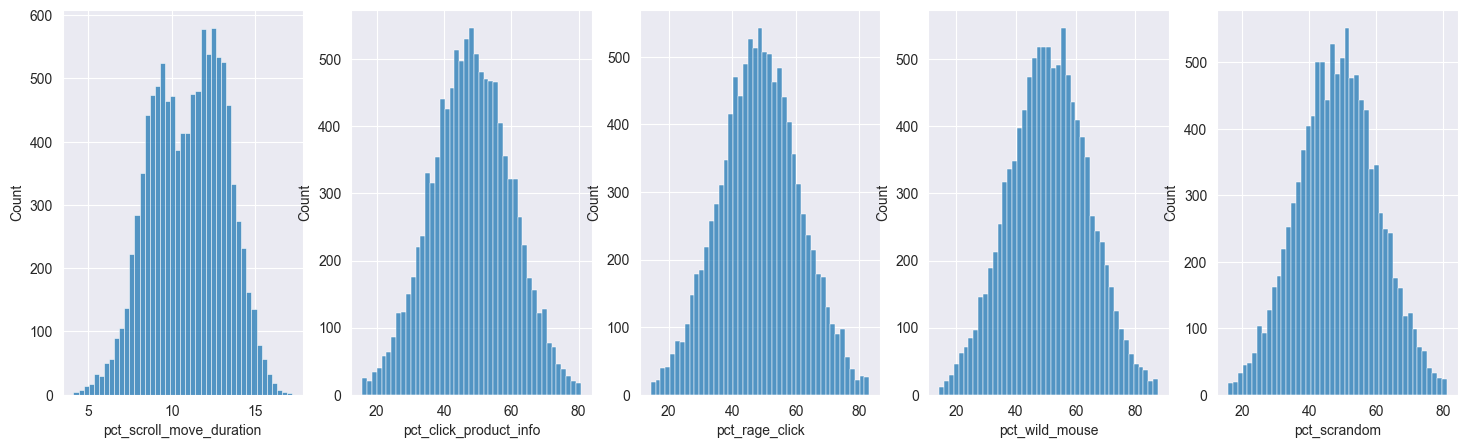

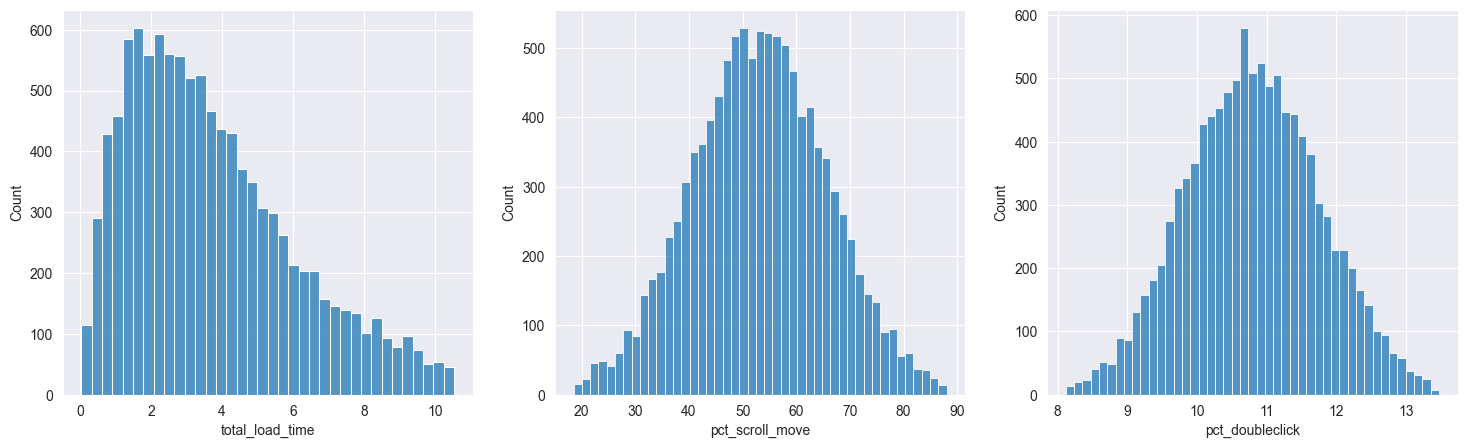

In [386]:
sessions_columns = [
    ["ack", "mouse_move_total_rel_distance", "pct_input", "pct_click", "pct_mouse_click"],
    ["wild_mouse_duration", "pct_mouse_move", "scroll_move_total_rel_distance", "session_duration", "page_activity_duration"],
    ["pct_scroll_move_duration", "pct_click_product_info", "pct_rage_click", "pct_wild_mouse", "pct_scrandom"],
    ["total_load_time", "pct_scroll_move", "pct_doubleclick"]
]
figs = []
axes = []

for i, columns in enumerate(sessions_columns):
    fig, ax = plt.subplots(1, len(columns), figsize=(18, 5))
    figs.append(fig)
    axes.append(ax)

for i, (fig, ax, columns) in enumerate(zip(figs, axes, sessions_columns)):
    for j, column in enumerate(columns):
        sns.histplot(data=sessions, x=column, ax=ax[j])

plt.show()

## Realizacia predspracovania dat

In [387]:
merged = sessions.merge(users, on="user_id", how="inner")

In [388]:
merged.duplicated().sum()

73

In [389]:
merged = merged.drop_duplicates()

In [390]:
merged = merged.drop(['session_id', 'user_id'], axis=1)

In [391]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5888 entries, 0 to 5960
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   pct_scroll_move_duration        5886 non-null   float64
 1   pct_click_product_info          5851 non-null   float64
 2   pct_click                       5887 non-null   float64
 3   pct_rage_click                  5832 non-null   float64
 4   pct_mouse_move                  5886 non-null   float64
 5   wild_mouse_duration             5885 non-null   float64
 6   pct_wild_mouse                  5860 non-null   float64
 7   scroll_move_total_rel_distance  5730 non-null   float64
 8   pct_scrandom                    5834 non-null   float64
 9   total_load_time                 5700 non-null   float64
 10  screen_height                   5888 non-null   int32  
 11  page_activity_duration          5843 non-null   float64
 12  pct_scroll_move                 5859 no

## Merged data rozdelime na trenovacie a testovacie

In [392]:
train_data, test_data = train_test_split(merged, test_size=0.2)